### Neural Network Transfer Learning
In this notebook we use transfer learning for our plant classification task, we perform tests using both ResNet18 and ResNet101

In [1]:
from __future__ import print_function, division

import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import os
import copy
from skimage import io
from PIL import Image
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

### Dataset creation

In [2]:
subset = 'train'
folder = "."+os.sep+"data"+os.sep
file =  subset + os.sep + subset + ".csv"

#Create mapping for labels, labels must be continuous numbers from 0 to n_classes-1
df = pd.read_csv(folder + file)
classes = df.classid.unique()
classes.sort()
classes_map = { classes[i]:i for i in range(len(classes)) }

In [3]:
# Extension of the PyTorch DataSet class which uses our data
class PlantsDataset(Dataset):
    """Plants dataset."""

    def __init__(self, csv_file, root_dir, classes, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.classes_map = classes

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                str(self.df.iloc[idx, 1]))
        image = io.imread(img_name + '.jpg')
        label = self.df.iloc[idx, 4]
        sample = {'image': image, 'label': classes_map[label]}

        if self.transform:
            sample['image'] = Image.fromarray(sample['image'])
            sample['image'] = self.transform(sample['image'])

        return sample

In [4]:
# Load Data
resized = 'resized2'
folder = "."+os.sep+"data"+os.sep

transform = transforms.Compose([
                    transforms.Resize(224),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

#Training Data
subset = 'train'
file =  subset + os.sep + subset + ".csv"
image_path = "."+os.sep+"data"+os.sep+resized+os.sep+subset+os.sep
trainset = PlantsDataset(csv_file=folder + file, root_dir=image_path, classes=classes_map, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=0)

#Validation Data
subset = 'validation'
file =  subset + os.sep + subset + ".csv"
image_path = "."+os.sep+"data"+os.sep+resized+os.sep+subset+os.sep
valset = PlantsDataset(csv_file=folder + file, root_dir=image_path, classes=classes_map, transform=transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=4,shuffle=False, num_workers=0)

#Test Data
subset = 'test'
file =  subset + os.sep + subset + ".csv"
image_path = "."+os.sep+"data"+os.sep+resized+os.sep+subset+os.sep
testset = PlantsDataset(csv_file=folder + file, root_dir=image_path, classes=classes_map, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,shuffle=False, num_workers=0)

image_datasets = { 'train' : trainset, 'val' : valset, 'test' : testset }
dataloaders = { 'train' : trainloader, 'val' : valloader, 'test' : testloader}
dataset_sizes = { 'train' : len(trainset), 'val' : len(valset), 'test' : len(testset) }

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Function definition

In [5]:
# Show an image for testing
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

In [6]:
# Function to train our neural network takes as input a model, a criterion, an optimizer an scheduler
# and the number of epochs we will train the network for

# Returns the best model found over the training, and history of the training and validation accuracy
# over each epoch
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    history = {"train" : list(), "val": list()}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for i, data in enumerate(dataloaders[phase], 0):
                inputs, labels = data['image'].to(device), data['label'].to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            history[phase].append(epoch_acc)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

In [7]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, data in enumerate(dataloaders['val']):
            inputs = data['image'].to(device)
            labels = data['label'].to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}, truth: {}'.format(preds[j],labels[j]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
# Gets the prediction array for the specified model and dataset
def get_preds(net, loader):
    preds = list()
    with torch.no_grad():
        for data in testloader:
            images, labels = data['image'].to(device), data['label'].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            preds.extend(predicted.cpu().detach().numpy())
    return preds

In [9]:
# Plots the confusion matrix
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          dimensions=(32,24),
                          savepath=None):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=dimensions)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    if savepath is not None:
        plt.savefig(savepath)
    plt.show()

In [10]:
# Plots the training and validation accuracies after training a network, the plot can be saved as an image
def plot_history(history, savepath = None):
    plt.plot(history['train'])
    plt.plot(history['val'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    ticks = list(range(len(history['train'])))
    names = list(range(1,len(history['train'])+1))
    plt.xticks(ticks, names)
    if savepath is not None:
        plt.savefig(savepath)
    plt.show()

### Finetuning the network

In [35]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

# Setting up the new output layer
model_ft.fc = nn.Linear(num_ftrs, len(classes))

# Send the model to GPU
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [36]:
model_ft, history = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 2.5294 Acc: 0.3484
val Loss: 1.0097 Acc: 0.7036

Epoch 1/24
----------
train Loss: 1.1142 Acc: 0.6891
val Loss: 0.6445 Acc: 0.7942

Epoch 2/24
----------
train Loss: 0.6546 Acc: 0.8229
val Loss: 0.5972 Acc: 0.8230

Epoch 3/24
----------
train Loss: 0.3557 Acc: 0.9103
val Loss: 0.4887 Acc: 0.8460

Epoch 4/24
----------
train Loss: 0.2209 Acc: 0.9535
val Loss: 0.5132 Acc: 0.8547

Epoch 5/24
----------
train Loss: 0.1364 Acc: 0.9755
val Loss: 0.5506 Acc: 0.8417

Epoch 6/24
----------
train Loss: 0.0972 Acc: 0.9861
val Loss: 0.5244 Acc: 0.8518

Epoch 7/24
----------
train Loss: 0.0711 Acc: 0.9904
val Loss: 0.4860 Acc: 0.8576

Epoch 8/24
----------
train Loss: 0.0533 Acc: 0.9966
val Loss: 0.4860 Acc: 0.8619

Epoch 9/24
----------
train Loss: 0.0653 Acc: 0.9899
val Loss: 0.4906 Acc: 0.8633

Epoch 10/24
----------
train Loss: 0.0553 Acc: 0.9914
val Loss: 0.4772 Acc: 0.8662

Epoch 11/24
----------
train Loss: 0.0421 Acc: 0.9957
val Loss: 0.4873 Acc: 0.8662

Ep

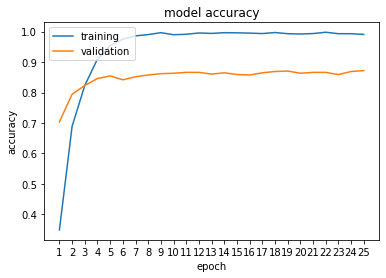

In [37]:
plot_history(history,'plots' + os.sep + 'model_ft.png')

In [38]:
y_predict = get_preds(model_ft, testloader)
y_true = image_datasets['test'].df['classid'].map(classes_map)
print("Accuracy: " + str(accuracy_score(y_true, y_predict)))
print("Rappel: " + str(recall_score(y_true, y_predict,average='weighted')))
print("Precision: " + str(precision_score(y_true, y_predict,average='weighted')))
print("F-Measure: " + str(f1_score(y_true, y_predict,average='weighted')))

Accuracy: 0.8575539568345324
Rappel: 0.8575539568345324
Precision: 0.8685791932204278
F-Measure: 0.8538337443337758


In [39]:
# Save Model 
PATH = 'models' + os.sep + 'model_ft.pth'
torch.save(model_ft.state_dict(), PATH)

### Network as fixed feature extractor

In [40]:
model_conv = torchvision.models.resnet18(pretrained=True)

# Freezing all the network
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(classes))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [41]:
model_conv, history = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 3.3508 Acc: 0.1823
val Loss: 2.0101 Acc: 0.4820

Epoch 1/24
----------
train Loss: 2.2100 Acc: 0.4395
val Loss: 1.3467 Acc: 0.6460

Epoch 2/24
----------
train Loss: 1.6991 Acc: 0.5902
val Loss: 1.0428 Acc: 0.7065

Epoch 3/24
----------
train Loss: 1.4219 Acc: 0.6377
val Loss: 1.0137 Acc: 0.6950

Epoch 4/24
----------
train Loss: 1.2580 Acc: 0.6761
val Loss: 0.9602 Acc: 0.7022

Epoch 5/24
----------
train Loss: 1.1523 Acc: 0.7011
val Loss: 0.8912 Acc: 0.7324

Epoch 6/24
----------
train Loss: 1.0551 Acc: 0.7279
val Loss: 0.8349 Acc: 0.7482

Epoch 7/24
----------
train Loss: 0.9146 Acc: 0.7836
val Loss: 0.7803 Acc: 0.7597

Epoch 8/24
----------
train Loss: 0.9066 Acc: 0.7783
val Loss: 0.7479 Acc: 0.7842

Epoch 9/24
----------
train Loss: 0.8882 Acc: 0.7917
val Loss: 0.7644 Acc: 0.7583

Epoch 10/24
----------
train Loss: 0.8729 Acc: 0.7970
val Loss: 0.7248 Acc: 0.7712

Epoch 11/24
----------
train Loss: 0.8813 Acc: 0.7908
val Loss: 0.7294 Acc: 0.7856

Ep

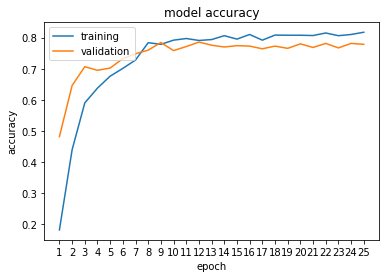

In [42]:
plot_history(history,'plots' + os.sep + 'model_conv.png')

In [43]:
y_predict = get_preds(model_conv, testloader)
y_true = image_datasets['test'].df['classid'].map(classes_map)
print("Accuracy: " + str(accuracy_score(y_true, y_predict)))
print("Rappel: " + str(recall_score(y_true, y_predict,average='weighted')))
print("Precision: " + str(precision_score(y_true, y_predict,average='weighted')))
print("F-Measure: " + str(f1_score(y_true, y_predict,average='weighted')))

Accuracy: 0.762589928057554
Rappel: 0.762589928057554
Precision: 0.782279893719554
F-Measure: 0.7558886238438675


In [44]:
# Save Model
PATH = 'models' + os.sep + 'model_conv.pth'
torch.save(model_conv.state_dict(), PATH)

### Adding dropout layer

In [11]:
model_dropout = models.resnet18(pretrained=True)
num_ftrs = model_dropout.fc.in_features

# Adding a droput layer just before the output layer
model_dropout.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, 50)
)

model_dropout = model_dropout.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_dropout = optim.SGD(model_dropout.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_dropout, step_size=7, gamma=0.1)

In [12]:
model_dropout, history = train_model(model_dropout, criterion, optimizer_dropout,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 2.9718 Acc: 0.2447
val Loss: 1.3599 Acc: 0.6043

Epoch 1/24
----------
train Loss: 1.6034 Acc: 0.5494
val Loss: 0.9607 Acc: 0.6906

Epoch 2/24
----------
train Loss: 1.1667 Acc: 0.6655
val Loss: 1.0184 Acc: 0.6892

Epoch 3/24
----------
train Loss: 0.8572 Acc: 0.7457
val Loss: 0.6863 Acc: 0.7871

Epoch 4/24
----------
train Loss: 0.6520 Acc: 0.8114
val Loss: 0.6534 Acc: 0.8173

Epoch 5/24
----------
train Loss: 0.4870 Acc: 0.8517
val Loss: 0.8695 Acc: 0.7741

Epoch 6/24
----------
train Loss: 0.3652 Acc: 0.8868
val Loss: 0.6946 Acc: 0.8216

Epoch 7/24
----------
train Loss: 0.2047 Acc: 0.9496
val Loss: 0.6358 Acc: 0.8417

Epoch 8/24
----------
train Loss: 0.1499 Acc: 0.9655
val Loss: 0.6140 Acc: 0.8489

Epoch 9/24
----------
train Loss: 0.1548 Acc: 0.9645
val Loss: 0.6263 Acc: 0.8417

Epoch 10/24
----------
train Loss: 0.1446 Acc: 0.9698
val Loss: 0.5760 Acc: 0.8403

Epoch 11/24
----------
train Loss: 0.1177 Acc: 0.9698
val Loss: 0.5773 Acc: 0.8446

Ep

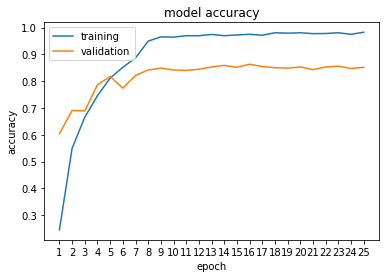

In [13]:
plot_history(history,'plots' + os.sep + 'model_dropout.png')

In [14]:
y_predict = get_preds(model_dropout, testloader)
y_true = image_datasets['test'].df['classid'].map(classes_map)
print("Accuracy: " + str(accuracy_score(y_true, y_predict)))
print("Rappel: " + str(recall_score(y_true, y_predict,average='weighted')))
print("Precision: " + str(precision_score(y_true, y_predict,average='weighted')))
print("F-Measure: " + str(f1_score(y_true, y_predict,average='weighted')))

Accuracy: 0.8503597122302158
Rappel: 0.8503597122302158
Precision: 0.8594120811885919
F-Measure: 0.8482066650505452


In [15]:
PATH = 'models' + os.sep + 'model_dropout.pth'
torch.save(model_dropout.state_dict(), PATH)

### Freezing all except last residual block

In [73]:
model_freeze = models.resnet18(pretrained=True)
num_ftrs = model_freeze.fc.in_features

model_freeze.fc = nn.Linear(num_ftrs, 50)

# Freeze all layers except last residual block and output fc layer
ct = 0
for child in model_freeze.children():
    ct += 1
    if ct < 8:
        for param in child.parameters():
            param.requires_grad = False

model_freeze = model_freeze.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that we only optimize parameters which have requires_grad = True
optimizer_freeze = optim.SGD(filter(lambda p: p.requires_grad, model_freeze.parameters()), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_freeze, step_size=7, gamma=0.1)

In [74]:
model_freeze, history = train_model(model_freeze, criterion, optimizer_freeze,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 2.5892 Acc: 0.3359
val Loss: 1.0220 Acc: 0.6791

Epoch 1/24
----------
train Loss: 1.1325 Acc: 0.6939
val Loss: 0.6992 Acc: 0.7755

Epoch 2/24
----------
train Loss: 0.7078 Acc: 0.8210
val Loss: 0.5823 Acc: 0.8273

Epoch 3/24
----------
train Loss: 0.4241 Acc: 0.9069
val Loss: 0.5392 Acc: 0.8302

Epoch 4/24
----------
train Loss: 0.2709 Acc: 0.9463
val Loss: 0.5127 Acc: 0.8331

Epoch 5/24
----------
train Loss: 0.1619 Acc: 0.9722
val Loss: 0.4821 Acc: 0.8475

Epoch 6/24
----------
train Loss: 0.1261 Acc: 0.9765
val Loss: 0.5783 Acc: 0.8245

Epoch 7/24
----------
train Loss: 0.1081 Acc: 0.9803
val Loss: 0.4948 Acc: 0.8547

Epoch 8/24
----------
train Loss: 0.1055 Acc: 0.9837
val Loss: 0.4694 Acc: 0.8576

Epoch 9/24
----------
train Loss: 0.0956 Acc: 0.9890
val Loss: 0.4808 Acc: 0.8561

Epoch 10/24
----------
train Loss: 0.0870 Acc: 0.9890
val Loss: 0.5036 Acc: 0.8417

Epoch 11/24
----------
train Loss: 0.0869 Acc: 0.9880
val Loss: 0.5047 Acc: 0.8504

Ep

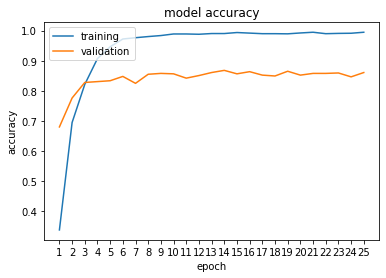

In [75]:
plot_history(history,'plots' + os.sep + 'model_freeze.png')

In [76]:
y_predict = get_preds(model_freeze, testloader)
y_true = image_datasets['test'].df['classid'].map(classes_map)
print("Accuracy: " + str(accuracy_score(y_true, y_predict)))
print("Rappel: " + str(recall_score(y_true, y_predict,average='weighted')))
print("Precision: " + str(precision_score(y_true, y_predict,average='weighted')))
print("F-Measure: " + str(f1_score(y_true, y_predict,average='weighted')))

Accuracy: 0.8532374100719424
Rappel: 0.8532374100719424
Precision: 0.8612680466938412
F-Measure: 0.8495212220053522


In [77]:
PATH = 'models' + os.sep + 'model_freeze.pth'
torch.save(model_freeze.state_dict(), PATH)

### With data augmentation

In [244]:
resized = 'resized2'
folder = "."+os.sep+"data"+os.sep

transform_aug = transforms.Compose([
                    transforms.Resize(224),
                    transforms.RandomRotation(20),
                    transforms.ColorJitter(brightness=0.4, contrast=0.4),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

#Training Data
subset = 'train'
file =  subset + os.sep + subset + ".csv"
image_path = "."+os.sep+"data"+os.sep+resized+os.sep+subset+os.sep
trainset = PlantsDataset(csv_file=folder + file, root_dir=image_path, classes=classes_map, transform=transform_aug)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=0)

image_datasets = { 'train' : trainset, 'val' : valset, 'test' : testset }
dataloaders = { 'train' : trainloader, 'val' : valloader, 'test' : testloader}
dataset_sizes = { 'train' : len(trainset), 'val' : len(valset), 'test' : len(testset) }

In [200]:
model_aug = models.resnet18(pretrained=True)
num_ftrs = model_aug.fc.in_features

model_aug.fc = nn.Linear(num_ftrs, len(classes))

model_aug = model_aug.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_aug = optim.SGD(model_aug.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_aug, step_size=7, gamma=0.1)

In [201]:
model_aug, history = train_model(model_aug, criterion, optimizer_aug, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 2.6872 Acc: 0.2965
val Loss: 1.0523 Acc: 0.6647

Epoch 1/24
----------
train Loss: 1.3841 Acc: 0.6123
val Loss: 0.7761 Acc: 0.7640

Epoch 2/24
----------
train Loss: 0.9833 Acc: 0.7294
val Loss: 0.7270 Acc: 0.7842

Epoch 3/24
----------
train Loss: 0.6924 Acc: 0.8023
val Loss: 0.5698 Acc: 0.8129

Epoch 4/24
----------
train Loss: 0.5377 Acc: 0.8479
val Loss: 0.6892 Acc: 0.7942

Epoch 5/24
----------
train Loss: 0.4795 Acc: 0.8661
val Loss: 0.6439 Acc: 0.8072

Epoch 6/24
----------
train Loss: 0.3427 Acc: 0.9031
val Loss: 0.5972 Acc: 0.8489

Epoch 7/24
----------
train Loss: 0.2035 Acc: 0.9559
val Loss: 0.5120 Acc: 0.8619

Epoch 8/24
----------
train Loss: 0.1540 Acc: 0.9698
val Loss: 0.4717 Acc: 0.8619

Epoch 9/24
----------
train Loss: 0.1410 Acc: 0.9717
val Loss: 0.4858 Acc: 0.8676

Epoch 10/24
----------
train Loss: 0.1612 Acc: 0.9655
val Loss: 0.4825 Acc: 0.8647

Epoch 11/24
----------
train Loss: 0.1337 Acc: 0.9726
val Loss: 0.4940 Acc: 0.8647

Ep

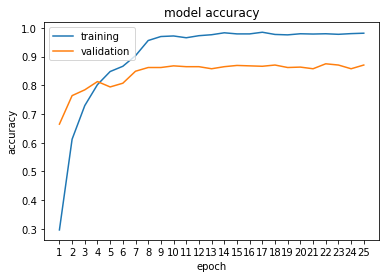

In [202]:
plot_history(history,'plots' + os.sep + 'model_aug.png')

In [203]:
y_predict = get_preds(model_aug, testloader)
y_true = image_datasets['test'].df['classid'].map(classes_map)
print("Accuracy: " + str(accuracy_score(y_true, y_predict)))
print("Rappel: " + str(recall_score(y_true, y_predict,average='weighted')))
print("Precision: " + str(precision_score(y_true, y_predict,average='weighted')))
print("F-Measure: " + str(f1_score(y_true, y_predict,average='weighted')))

Accuracy: 0.8733812949640288
Rappel: 0.8733812949640288
Precision: 0.8812193740237041
F-Measure: 0.8700928547959084


In [204]:
# Save Model 
PATH = 'models' + os.sep + 'model_aug.pth'
torch.save(model_aug.state_dict(), PATH)

### Data aug + freeze

In [245]:
model_aug_freeze = models.resnet18(pretrained=True)
num_ftrs = model_aug_freeze.fc.in_features

model_aug_freeze.fc = nn.Linear(num_ftrs, len(classes))

# Freeze all layers except conv5_x block and output fc layer
for name, child in model_aug_freeze.named_children():
   if name in ['layer4','fc']:
       print(name + ' is unfrozen')
       for param in child.parameters():
           param.requires_grad = True
   else:
       print(name + ' is frozen')
       for param in child.parameters():
           param.requires_grad = False

model_aug_freeze = model_aug_freeze.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that we only optimize parameters which have requires_grad = True
optimizer_aug_freeze = optim.SGD(filter(lambda p: p.requires_grad, model_aug_freeze.parameters()), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_aug_freeze, step_size=7, gamma=0.1)

conv1 is frozen
bn1 is frozen
relu is frozen
maxpool is frozen
layer1 is frozen
layer2 is frozen
layer3 is frozen
layer4 is unfrozen
avgpool is frozen
fc is unfrozen


In [246]:
model_aug_freeze, history = train_model(model_aug_freeze, criterion, optimizer_aug_freeze, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 2.7718 Acc: 0.2788
val Loss: 1.2301 Acc: 0.6144

Epoch 1/24
----------
train Loss: 1.4893 Acc: 0.5897
val Loss: 0.8068 Acc: 0.7353

Epoch 2/24
----------
train Loss: 1.0346 Acc: 0.7164
val Loss: 0.7053 Acc: 0.7669

Epoch 3/24
----------
train Loss: 0.7800 Acc: 0.7716
val Loss: 0.6613 Acc: 0.7741

Epoch 4/24
----------
train Loss: 0.6420 Acc: 0.8095
val Loss: 0.6011 Acc: 0.8173

Epoch 5/24
----------
train Loss: 0.4673 Acc: 0.8685
val Loss: 0.5630 Acc: 0.8273

Epoch 6/24
----------
train Loss: 0.3694 Acc: 0.8954
val Loss: 0.5909 Acc: 0.8288

Epoch 7/24
----------
train Loss: 0.2939 Acc: 0.9304
val Loss: 0.5388 Acc: 0.8460

Epoch 8/24
----------
train Loss: 0.2659 Acc: 0.9391
val Loss: 0.5139 Acc: 0.8432

Epoch 9/24
----------
train Loss: 0.2481 Acc: 0.9424
val Loss: 0.5153 Acc: 0.8504

Epoch 10/24
----------
train Loss: 0.2198 Acc: 0.9525
val Loss: 0.5133 Acc: 0.8518

Epoch 11/24
----------
train Loss: 0.2062 Acc: 0.9602
val Loss: 0.4724 Acc: 0.8647

Ep

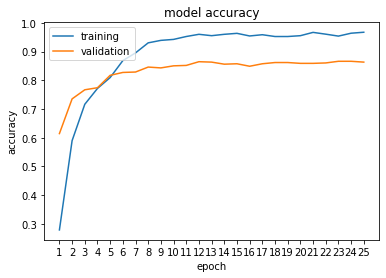

In [247]:
plot_history(history,'plots' + os.sep + 'model_aug_freeze.png')

In [248]:
y_predict = get_preds(model_aug_freeze, testloader)
y_true = image_datasets['test'].df['classid'].map(classes_map)
print("Accuracy: " + str(accuracy_score(y_true, y_predict)))
print("Rappel: " + str(recall_score(y_true, y_predict,average='weighted')))
print("Precision: " + str(precision_score(y_true, y_predict,average='weighted')))
print("F-Measure: " + str(f1_score(y_true, y_predict,average='weighted')))

Accuracy: 0.8460431654676259
Rappel: 0.8460431654676259
Precision: 0.8568634471526647
F-Measure: 0.843929198213493


In [249]:
# Save Model 
PATH = 'models' + os.sep + 'model_aug_freeze.pth'
torch.save(model_aug_freeze.state_dict(), PATH)

### Deeper Resnet

In [294]:
resized = 'resized2'
folder = "."+os.sep+"data"+os.sep

transform = transforms.Compose([
                    transforms.Resize(224),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

#Training Data
subset = 'train'
file =  subset + os.sep + subset + ".csv"
image_path = "."+os.sep+"data"+os.sep+resized+os.sep+subset+os.sep
trainset = PlantsDataset(csv_file=folder + file, root_dir=image_path, classes=classes_map, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=0)

image_datasets = { 'train' : trainset, 'val' : valset, 'test' : testset }
dataloaders = { 'train' : trainloader, 'val' : valloader, 'test' : testloader}
dataset_sizes = { 'train' : len(trainset), 'val' : len(valset), 'test' : len(testset) }

### Unfreeze layer 4

In [296]:
model_101_layer4 = models.resnet101(pretrained=True)
num_ftrs = model_101_layer4.fc.in_features

model_101_layer4.fc = nn.Linear(num_ftrs, len(classes))

# Freeze all layers except conv5_x and output fc layer
for name, child in model_101_layer4.named_children():
   if name in ['layer4','fc']:
       print(name + ' is unfrozen')
       for param in child.parameters():
           param.requires_grad = True
   else:
       print(name + ' is frozen')
       for param in child.parameters():
           param.requires_grad = False

model_101_layer4 = model_101_layer4.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that we only optimize parameters which have requires_grad = True
optimizer_101_layer4 = optim.SGD(filter(lambda p: p.requires_grad, model_101_layer4.parameters()), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_101_layer4, step_size=7, gamma=0.1)

conv1 is frozen
bn1 is frozen
relu is frozen
maxpool is frozen
layer1 is frozen
layer2 is frozen
layer3 is frozen
layer4 is unfrozen
avgpool is frozen
fc is unfrozen


In [297]:
model_101_layer4, history = train_model(model_101_layer4, criterion, optimizer_101_layer4, exp_lr_scheduler,
                       num_epochs=15)

Epoch 0/14
----------
train Loss: 2.6937 Acc: 0.3105
val Loss: 1.6459 Acc: 0.6173

Epoch 1/14
----------
train Loss: 1.2686 Acc: 0.6257
val Loss: 2.3775 Acc: 0.7122

Epoch 2/14
----------
train Loss: 0.7721 Acc: 0.7836
val Loss: 2.7031 Acc: 0.7525

Epoch 3/14
----------
train Loss: 0.5148 Acc: 0.8560
val Loss: 3.9583 Acc: 0.7799

Epoch 4/14
----------
train Loss: 0.3410 Acc: 0.9131
val Loss: 1.4232 Acc: 0.8029

Epoch 5/14
----------
train Loss: 0.2484 Acc: 0.9434
val Loss: 3.3473 Acc: 0.7842

Epoch 6/14
----------
train Loss: 0.2039 Acc: 0.9515
val Loss: 2.1374 Acc: 0.8014

Epoch 7/14
----------
train Loss: 0.1228 Acc: 0.9779
val Loss: 3.7746 Acc: 0.8058

Epoch 8/14
----------
train Loss: 0.1092 Acc: 0.9789
val Loss: 5.5458 Acc: 0.7741

Epoch 9/14
----------
train Loss: 0.1122 Acc: 0.9808
val Loss: 8.0996 Acc: 0.7554

Epoch 10/14
----------
train Loss: 0.1069 Acc: 0.9808
val Loss: 7.5153 Acc: 0.7655

Epoch 11/14
----------
train Loss: 0.0860 Acc: 0.9818
val Loss: 3.9806 Acc: 0.7813

Ep

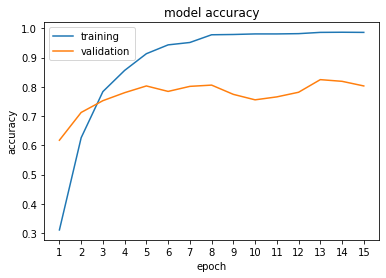

In [298]:
plot_history(history,'plots' + os.sep + 'model_101_layer4.png')

In [299]:
y_predict = get_preds(model_101_layer4, testloader)
y_true = image_datasets['test'].df['classid'].map(classes_map)
print("Accuracy: " + str(accuracy_score(y_true, y_predict)))
print("Rappel: " + str(recall_score(y_true, y_predict,average='weighted')))
print("Precision: " + str(precision_score(y_true, y_predict,average='weighted')))
print("F-Measure: " + str(f1_score(y_true, y_predict,average='weighted')))

Accuracy: 0.818705035971223
Rappel: 0.818705035971223
Precision: 0.8551813975028445
F-Measure: 0.8178352862499464


In [300]:
# Save Model 
PATH = 'models' + os.sep + 'model_101_layer4.pth'
torch.save(model_101_layer4.state_dict(), PATH)

### Unfreeze layers 3 and 4

In [175]:
model_101 = models.resnet101(pretrained=True)
num_ftrs = model_101.fc.in_features

model_101.fc = nn.Linear(num_ftrs, len(classes))

# Freeze all layers except conv4_x, conv5_x and output fc layer
for name, child in model_101.named_children():
   if name in ['layer3','layer4','fc']:
       print(name + ' is unfrozen')
       for param in child.parameters():
           param.requires_grad = True
   else:
       print(name + ' is frozen')
       for param in child.parameters():
           param.requires_grad = False

model_101 = model_101.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that we only optimize parameters which have requires_grad = True
optimizer_101 = optim.SGD(filter(lambda p: p.requires_grad, model_101.parameters()), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_101, step_size=7, gamma=0.1)

conv1 is frozen
bn1 is frozen
relu is frozen
maxpool is frozen
layer1 is frozen
layer2 is frozen
layer3 is unfrozen
layer4 is unfrozen
avgpool is frozen
fc is unfrozen


In [176]:
model_101, history = train_model(model_101, criterion, optimizer_101, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
train Loss: 2.5307 Acc: 0.3532
val Loss: 1.2283 Acc: 0.6633

Epoch 1/9
----------
train Loss: 1.0215 Acc: 0.7102
val Loss: 0.6843 Acc: 0.8000

Epoch 2/9
----------
train Loss: 0.5616 Acc: 0.8503
val Loss: 0.5751 Acc: 0.8388

Epoch 3/9
----------
train Loss: 0.3052 Acc: 0.9256
val Loss: 0.6435 Acc: 0.8432

Epoch 4/9
----------
train Loss: 0.1980 Acc: 0.9501
val Loss: 0.6044 Acc: 0.8504

Epoch 5/9
----------
train Loss: 0.1337 Acc: 0.9702
val Loss: 0.7205 Acc: 0.8403

Epoch 6/9
----------
train Loss: 0.1100 Acc: 0.9803
val Loss: 0.6269 Acc: 0.8619

Epoch 7/9
----------
train Loss: 0.0792 Acc: 0.9875
val Loss: 0.5974 Acc: 0.8676

Epoch 8/9
----------
train Loss: 0.0585 Acc: 0.9899
val Loss: 0.5279 Acc: 0.8849

Epoch 9/9
----------
train Loss: 0.0650 Acc: 0.9861
val Loss: 0.5071 Acc: 0.8892

Training complete in 17m 28s
Best val Acc: 0.889209


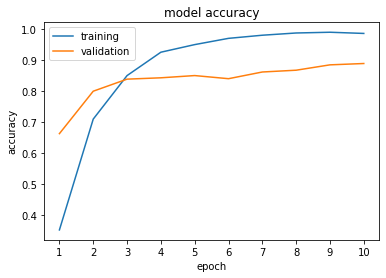

In [177]:
plot_history(history,'plots' + os.sep + 'model_101.png')

In [178]:
y_predict = get_preds(model_101, testloader)
y_true = image_datasets['test'].df['classid'].map(classes_map)
print("Accuracy: " + str(accuracy_score(y_true, y_predict)))
print("Rappel: " + str(recall_score(y_true, y_predict,average='weighted')))
print("Precision: " + str(precision_score(y_true, y_predict,average='weighted')))
print("F-Measure: " + str(f1_score(y_true, y_predict,average='weighted')))

Accuracy: 0.8719424460431655
Rappel: 0.8719424460431655
Precision: 0.8768210586376055
F-Measure: 0.8674342646297888


In [179]:
# Save Model 
PATH = 'models' + os.sep + 'model_101.pth'
torch.save(model_101.state_dict(), PATH)

### Deeper resnet with augmentation

In [237]:
resized = 'resized2'
folder = "."+os.sep+"data"+os.sep

transform_aug = transforms.Compose([
                    transforms.Resize(224),
                    transforms.RandomRotation(30),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

#Training Data
subset = 'train'
file =  subset + os.sep + subset + ".csv"
image_path = "."+os.sep+"data"+os.sep+resized+os.sep+subset+os.sep
trainset = PlantsDataset(csv_file=folder + file, root_dir=image_path, classes=classes_map, transform=transform_aug)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=0)

image_datasets = { 'train' : trainset, 'val' : valset, 'test' : testset }
dataloaders = { 'train' : trainloader, 'val' : valloader, 'test' : testloader}
dataset_sizes = { 'train' : len(trainset), 'val' : len(valset), 'test' : len(testset) }

In [238]:
model_101_aug = models.resnet101(pretrained=True)
num_ftrs = model_101_aug.fc.in_features

model_101_aug.fc = nn.Linear(num_ftrs, len(classes))

# Freeze all layers except conv4_x, conv5_x and output fc layer
for name, child in model_101_aug.named_children():
   if name in ['layer3','layer4','fc']:
       print(name + ' is unfrozen')
       for param in child.parameters():
           param.requires_grad = True
   else:
       print(name + ' is frozen')
       for param in child.parameters():
           param.requires_grad = False

model_101_aug = model_101_aug.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that we only optimize parameters which have requires_grad = True
optimizer_101_aug = optim.SGD(filter(lambda p: p.requires_grad, model_101_aug.parameters()), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_101_aug, step_size=7, gamma=0.1)

conv1 is frozen
bn1 is frozen
relu is frozen
maxpool is frozen
layer1 is frozen
layer2 is frozen
layer3 is unfrozen
layer4 is unfrozen
avgpool is frozen
fc is unfrozen


In [240]:
model_101_aug, history = train_model(model_101_aug, criterion, optimizer_101_aug, exp_lr_scheduler,
                       num_epochs=20)

Epoch 0/19
----------
train Loss: 2.5525 Acc: 0.3330
val Loss: 1.1719 Acc: 0.6604

Epoch 1/19
----------
train Loss: 1.2416 Acc: 0.6396
val Loss: 0.6275 Acc: 0.7957

Epoch 2/19
----------
train Loss: 0.7613 Acc: 0.7845
val Loss: 0.6603 Acc: 0.8101

Epoch 3/19
----------
train Loss: 0.5933 Acc: 0.8277
val Loss: 0.6878 Acc: 0.7986

Epoch 4/19
----------
train Loss: 0.4505 Acc: 0.8647
val Loss: 1.0307 Acc: 0.7856

Epoch 5/19
----------
train Loss: 0.3305 Acc: 0.9031
val Loss: 0.8927 Acc: 0.8245

Epoch 6/19
----------
train Loss: 0.3062 Acc: 0.9112
val Loss: 0.5191 Acc: 0.8633

Epoch 7/19
----------
train Loss: 0.1800 Acc: 0.9520
val Loss: 0.4253 Acc: 0.8935

Epoch 8/19
----------
train Loss: 0.1352 Acc: 0.9645
val Loss: 0.4375 Acc: 0.8892

Epoch 9/19
----------
train Loss: 0.1204 Acc: 0.9683
val Loss: 0.3876 Acc: 0.8950

Epoch 10/19
----------
train Loss: 0.1130 Acc: 0.9750
val Loss: 0.3888 Acc: 0.8964

Epoch 11/19
----------
train Loss: 0.0851 Acc: 0.9837
val Loss: 0.4152 Acc: 0.8892

Ep

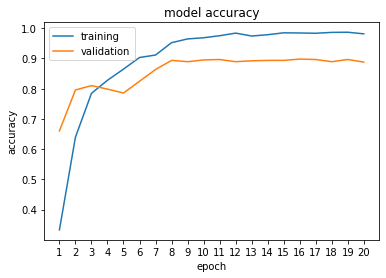

In [241]:
plot_history(history,'plots' + os.sep + 'model_101_aug.png')

In [261]:
y_predict = get_preds(model_101_aug, testloader)
y_true = image_datasets['test'].df['classid'].map(classes_map)
print("Accuracy: " + str(accuracy_score(y_true, y_predict)))
print("Rappel: " + str(recall_score(y_true, y_predict,average='weighted')))
print("Precision: " + str(precision_score(y_true, y_predict,average='weighted')))
print("F-Measure: " + str(f1_score(y_true, y_predict,average='weighted')))

Accuracy: 0.883453237410072
Rappel: 0.883453237410072
Precision: 0.8902428294186653
F-Measure: 0.879251658167394


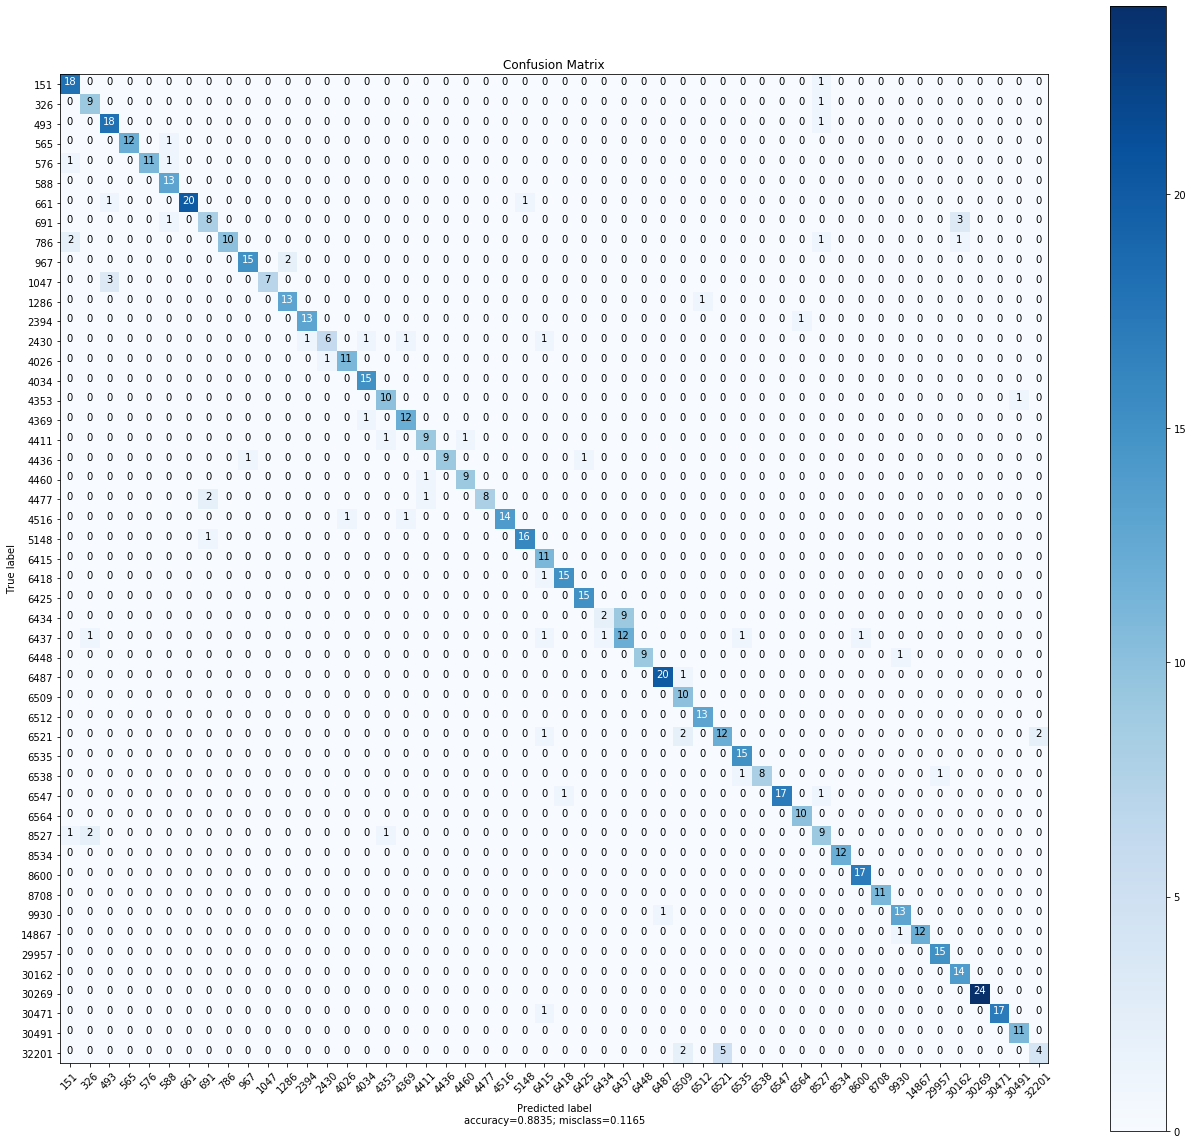

In [263]:
cm = confusion_matrix(y_true, y_predict)
plot_confusion_matrix(cm=cm,normalize=False,target_names=classes,
                      title="Confusion Matrix",savepath='plots' + os.sep + 'cm_model_101_aug.png',
                      dimensions=(18,16))

In [243]:
PATH = 'models' + os.sep + 'model_101_aug.pth'
torch.save(model_101_aug.state_dict(), PATH)

### Load Model Test

In [ ]:
# Testing how to load a previously saved model

# Load Model FT
PATH = './model_ft.pth'
net = torchvision.models.resnet18()

# Adding the output layer
num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 50)

# Load weights and send NN to device (GPU if available)
net.load_state_dict(torch.load(PATH))
net = net.to(device)

In [ ]:
# Testing the model loads properly 
visualize_model(net)